In [3]:
'''
This is a file for the strategy implementation and parameter optimization.
The strategy is based on the combination of RSI, Stochastic Oscillator.
Using the vectorbt library to implement the strategy and optimize the parameters.
'''
import numpy as np
import pandas
import vectorbt as vbt
data = pandas.read_csv('./data/BTCUSDT_1h.csv')
data = data.set_index('close_time')
data.index = pandas.to_datetime(data.index)
data=data[(data.index > '2020-01-01') & (data.index < '2022-09-01')]
RSI = vbt.IndicatorFactory.from_talib("RSI")
STOCH = vbt.IndicatorFactory.from_talib("STOCH")
print(data)

                     Unnamed: 0            open_time      open      high  \
close_time                                                                 
2020-01-01 01:00:00           1  2020-01-01 01:00:00   7171.43   7225.00   
2020-01-01 02:00:00           2  2020-01-01 02:00:00   7210.38   7239.30   
2020-01-01 03:00:00           3  2020-01-01 03:00:00   7237.41   7239.74   
2020-01-01 04:00:00           4  2020-01-01 04:00:00   7221.80   7225.41   
2020-01-01 05:00:00           5  2020-01-01 05:00:00   7213.86   7224.09   
...                         ...                  ...       ...       ...   
2022-08-31 19:00:00         739  2022-08-31 19:00:00  19993.90  20329.00   
2022-08-31 20:00:00         740  2022-08-31 20:00:00  20217.70  20232.70   
2022-08-31 21:00:00         741  2022-08-31 21:00:00  20186.50  20288.70   
2022-08-31 22:00:00         742  2022-08-31 22:00:00  20272.20  20285.60   
2022-08-31 23:00:00         743  2022-08-31 23:00:00  20148.30  20148.30   

           

In [6]:
'''
Strategy Implementation for long strategy
'''
import numpy as np
import pandas
import vectorbt as vbt
from numba import njit


@njit
def crossabove(a, b):
    return (a[:-1] <= b[:-1]) & (a[1:] > b[1:])

@njit
def crossbelow(a, b):
    return (a[:-1] >= b[:-1]) & (a[1:] < b[1:])

@njit
def produce_signal(rsi_values, slowk_values, slowd_values):
    # 計算交叉
    cross_up = crossabove(slowk_values, slowd_values)
    cross_down = crossbelow(slowk_values, slowd_values)

    trend = np.zeros(len(rsi_values), dtype=np.int32)

    for i in range(1, len(rsi_values)):
        if  rsi_values[i]>60 and cross_up[i-1]:
            trend[i] = 1
        elif rsi_values[i]<40:
            trend[i] = -1

    return trend



def custom_indicator(close, high, low, rsi_window=32, fastk_period=9, slowk_period=3,slowd_period=3):
    # Calculate RSI
    rsi = RSI.run(close, rsi_window).real
    stoch = STOCH.run(
        high,
        low,
        close,
        fastk_period=fastk_period,
        slowk_period=slowk_period,
        slowk_matype=0,
        slowd_period=slowd_period,
        slowd_matype=0
    )

    rsi_values = rsi.to_numpy()
    slowk_values = stoch.slowk.to_numpy()
    slowd_values = stoch.slowd.to_numpy()


    # Ensure no NaNs

    rsi_values = np.nan_to_num(rsi_values)
    slowk_values = np.nan_to_num(slowk_values)
    slowd_values = np.nan_to_num(slowd_values)

    return produce_signal(rsi_values,slowk_values,slowd_values)

# Define the custom indicator using IndicatorFactory
ind = vbt.IndicatorFactory(
    class_name="Combination",
    short_name="comb",
    input_names=['close', 'high', 'low'],
    param_names=['rsi_window', 'fastk_period', 'slowk_period', 'slowd_period'],
    output_names=["value"]
).from_apply_func(
    custom_indicator,
    rsi_window=32,
    fastk_period=9,
    slowk_period=3,
    slowd_period=3)

# Run the indicator
res = ind.run(
    data['close'],
    data['high'],
    data['low'],
    rsi_window=32,
    fastk_period=20,
    slowk_period=3,
    slowd_period=3,
)

# Generate entries and exits signals
entries = res.value == 1
exits = res.value == -1

# Create a portfolio from the signals
pf = vbt.Portfolio.from_signals(data['close'], entries, exits,freq='1h',direction='longonly',fees=0.04/100,sl_stop=0.05)
print(pf.stats())
fig = pf.plots(subplots=['trades'])
fig.show()
# 'orders', 'trades', 'drawdowns', 'underwater', 'trade_pnl','cum_returns'


Start                                2020-01-01 01:00:00
End                                  2022-08-31 23:00:00
Period                                 969 days 23:00:00
Start Value                                        100.0
End Value                                     719.292002
Total Return [%]                              619.292002
Benchmark Return [%]                          177.958847
Max Gross Exposure [%]                             100.0
Total Fees Paid                                25.408106
Max Drawdown [%]                               31.766231
Max Drawdown Duration                  311 days 08:00:00
Total Trades                                          59
Total Closed Trades                                   59
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   44.067797
Best Trade [%]                                 88.280207
Worst Trade [%]                

In [4]:
'''
This Block is long strategy implementation and parameter optimization.
'''

import numpy as np
import pandas
import vectorbt as vbt
from numba import njit


@njit
def cross_above(a, b): #cross above function
    return (a[:-1] <= b[:-1]) & (a[1:] > b[1:])

@njit
def cross_below(a, b): #cross below function
    return (a[:-1] >= b[:-1]) & (a[1:] < b[1:])

@njit
def produce_signal(rsi_values, slowk_values, slowd_values):   #produce signal function
    cross = cross_above(slowk_values,slowd_values)    #cross down signal
    trend = np.zeros(len(rsi_values), dtype=np.int32)
    for i in range(1, len(rsi_values)):
        if rsi_values[i] > 60 and cross[i-1] :
            trend[i] = 1
        elif rsi_values[i] < 40:
            trend[i] = -1
    return trend



def custom_indicator(close, high, low, rsi_window=32, fastk_period=9, slowk_period=3,slowd_period=3):
    rsi = RSI.run(close, rsi_window).real# Calculate RSI
    stoch = STOCH.run(                     # Calculate Stochastic Oscillator 
        high,
        low,
        close,
        fastk_period=fastk_period,
        slowk_period=slowk_period,
        slowk_matype=0,
        slowd_period=slowd_period,
        slowd_matype=0
    )

    # Convert to numpy arrays
    rsi_values = rsi.to_numpy()
    slowk_values = stoch.slowk.to_numpy()
    slowd_values = stoch.slowd.to_numpy()

    # Ensure no NaNs
    rsi_values = np.nan_to_num(rsi_values)
    slowk_values = np.nan_to_num(slowk_values)
    slowd_values = np.nan_to_num(slowd_values)

    return produce_signal(rsi_values,slowk_values,slowd_values)

# Define the custom indicator using IndicatorFactory
ind = vbt.IndicatorFactory(
    class_name="Combination",
    short_name="comb",
    input_names=['close', 'high', 'low'],
    param_names=['rsi_window', 'fastk_period', 'slowk_period', 'slowd_period'],
    output_names=["value"]
).from_apply_func(
    custom_indicator,
    rsi_window=32,
    fastk_period=9,
    slowk_period=3,
    slowd_period=3)

# Run the indicator
res = ind.run(
    data['close'],
    data['high'],
    data['low'],
    rsi_window=np.arange(10,50,1),
    fastk_period=np.arange(1,30,1),
    slowk_period=3,
    slowd_period=3,
    param_product=True
)

# Generate entries and exits signals
entries = res.value == 1
exits = res.value == -1

# Create a portfolio from the signals
long_pf = vbt.Portfolio.from_signals(data['close'], entries, exits,freq='1h',direction='longonly',fees=0.05/100,sl_stop=0.05)
long_returns = long_pf.returns()
long_sharpe = long_pf.sharpe_ratio()
long_mdd=long_pf.max_drawdown()



In [5]:
fig=long_pf.total_return().vbt.heatmap(
    x_level='comb_rsi_window',
    y_level='comb_fastk_period',
)
fig.show()

MultiIndex([(33, 24, 3, 3),
            (33, 25, 3, 3),
            (33, 20, 3, 3),
            (32, 24, 3, 3),
            (32, 17, 3, 3)],
           names=['comb_rsi_window', 'comb_fastk_period', 'comb_slowk_period', 'comb_slowd_period'])


<Axes: xlabel='close_time'>

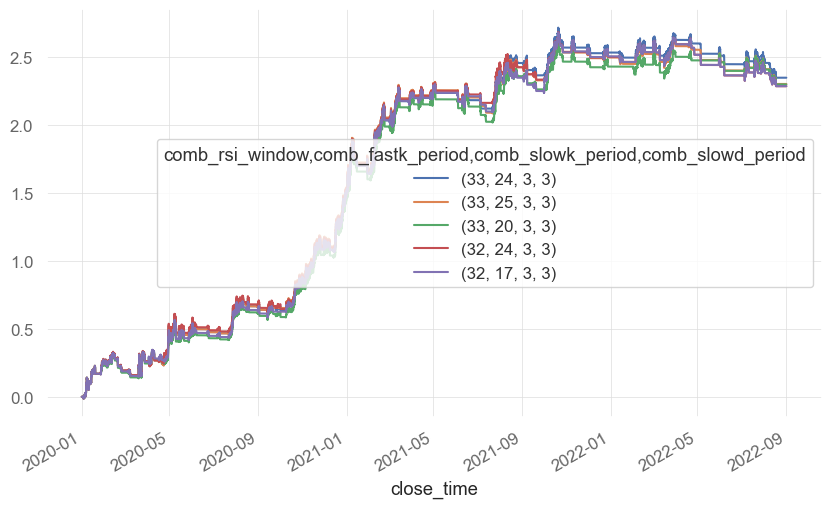

In [38]:
idx = long_sharpe.sort_values(ascending=False).index[:5]
print(idx)
long_pf.returns().loc[:,idx].cumsum().plot()

In [33]:
'''
This Block is for short strategy implementation and parameter optimization.
'''

import numpy as np
import pandas
import vectorbt as vbt
from numba import njit



@njit
def cross_above(a, b): #cross above function
    return (a[:-1] <= b[:-1]) & (a[1:] > b[1:])

@njit
def cross_below(a, b): #cross below function
    return (a[:-1] >= b[:-1]) & (a[1:] < b[1:])

@njit                  
def produce_signal(rsi_values, slowk_values, slowd_values):   #produce signal function
    cross = cross_below(slowk_values,slowd_values)    #cross down signal
    trend = np.zeros(len(rsi_values), dtype=np.int32)
    for i in range(1, len(rsi_values)):
        if rsi_values[i] < 40 and cross[i-1] :
            trend[i] = 1
        elif rsi_values[i] > 60:
            trend[i] = -1

    return trend



def custom_indicator(close, high, low, rsi_window=32, fastk_period=9, slowk_period=3,slowd_period=3):
    
    rsi = RSI.run(close, rsi_window).real# Calculate RSI
    stoch = STOCH.run(     # Calculate Stochastic Oscillator 
        high,
        low,
        close,
        fastk_period=fastk_period,
        slowk_period=slowk_period,
        slowk_matype=0,
        slowd_period=slowd_period,
        slowd_matype=0
    )

    # Convert to numpy arrays
    rsi_values = rsi.to_numpy()
    slowk_values = stoch.slowk.to_numpy()
    slowd_values = stoch.slowd.to_numpy()

    # Ensure no NaNs
    rsi_values = np.nan_to_num(rsi_values)
    slowk_values = np.nan_to_num(slowk_values)
    slowd_values = np.nan_to_num(slowd_values)

    return produce_signal(rsi_values,slowk_values,slowd_values)

# Define the custom indicator using IndicatorFactory
ind = vbt.IndicatorFactory(
    class_name="Combination",
    short_name="comb",
    input_names=['close', 'high', 'low'],
    param_names=['rsi_window', 'fastk_period', 'slowk_period', 'slowd_period'],
    output_names=["value"]
).from_apply_func(
    custom_indicator,
    rsi_window=32,
    fastk_period=9,
    slowk_period=3,
    slowd_period=3)

# Run the indicator
res = ind.run(
    data['close'],
    data['high'],
    data['low'],
    rsi_window=np.arange(10,50,1),
    fastk_period=np.arange(1,30,1),
    slowk_period=3,
    slowd_period=3,
    param_product=True
)

# Generate entries and exits signals
entries = res.value == 1
exits = res.value == -1

# Create a portfolio from the signals
short_pf = vbt.Portfolio.from_signals(data['close'], entries, exits,freq='1h', direction='shortonly',fees=0.05/100,sl_stop=0.05)
short_returns = short_pf.returns()
short_sharpe = short_pf.sharpe_ratio()
short_mdd=short_pf.max_drawdown()



In [34]:
fig=short_pf.total_return().vbt.heatmap(
    x_level='comb_rsi_window',
    y_level='comb_fastk_period',
)
fig.show()

In [35]:
fig=short_pf.sharpe_ratio().vbt.heatmap(
    x_level='comb_rsi_window',
    y_level='comb_fastk_period',
)
fig.show()

MultiIndex([(49, 18, 3, 3),
            (49, 27, 3, 3),
            (49, 26, 3, 3),
            (49, 29, 3, 3),
            (49, 28, 3, 3)],
           names=['comb_rsi_window', 'comb_fastk_period', 'comb_slowk_period', 'comb_slowd_period'])


<Axes: xlabel='close_time'>

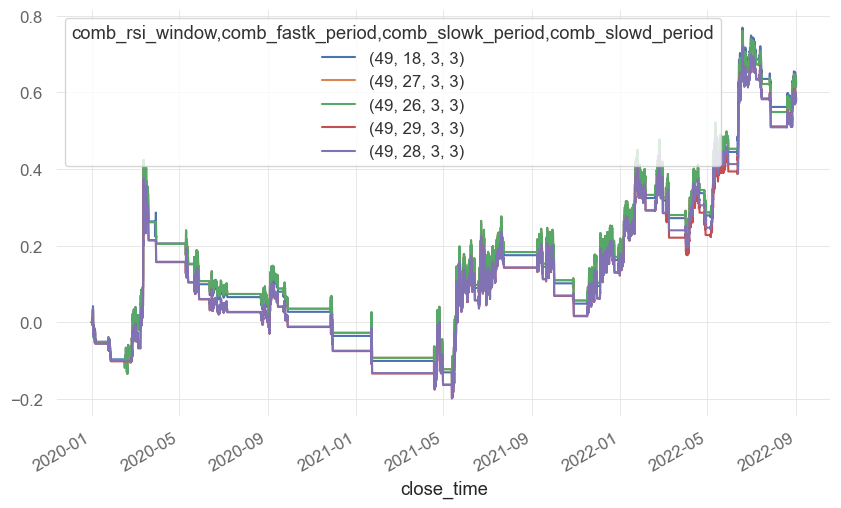

In [36]:
tmp = short_sharpe.sort_values(ascending=False)
tmp = tmp.loc[tmp.index.get_level_values(0) < 55]
idx = tmp.index[:5]
print(idx)
short_pf.returns().loc[:,idx].cumsum().plot()